In [1]:
# !pip install convertdate
# !pip install openpyxl
# !pip install  fbprophet holidays  pyluach

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from prophet import Prophet
#from fbprophet import Prophet
from pyluach import dates, hebrewcal
import holidays
#from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
#drive.mount('/content/drive/', force_remount=True)
#file_path = '/content/drive/My Drive/project data.csv'
file_path = ('project data.csv')
df = pd.read_csv(file_path)

# Part 1 - Data Selection, Visualization, and Introduction

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
weekly_data = df.resample('W-SAT').sum() # Resample the data by week. 'W-SAT' means weeks ending on Saturday.
weekly_data = weekly_data.iloc[1:]  # Remove the first row if it does not represent a complete week
cutoff_date = pd.Timestamp('2020-03-01')# Set cutoff date to remove empty data entries after this point
weekly_data = weekly_data[weekly_data.index < cutoff_date]


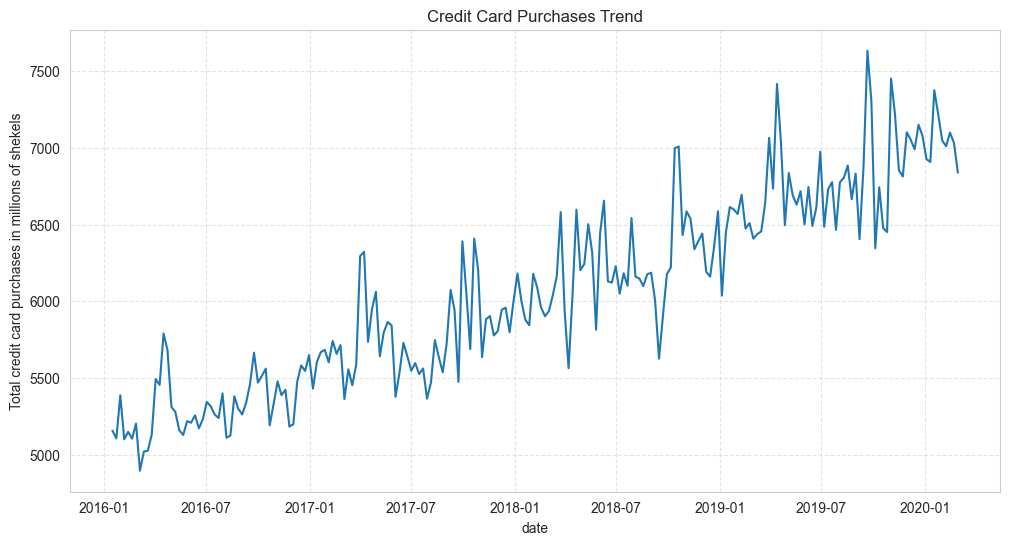

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_data, x='date', y='Total credit card purchases in millions of shekels')
plt.title("Credit Card Purchases Trend")
plt.grid(True, linestyle='--', alpha=0.5)

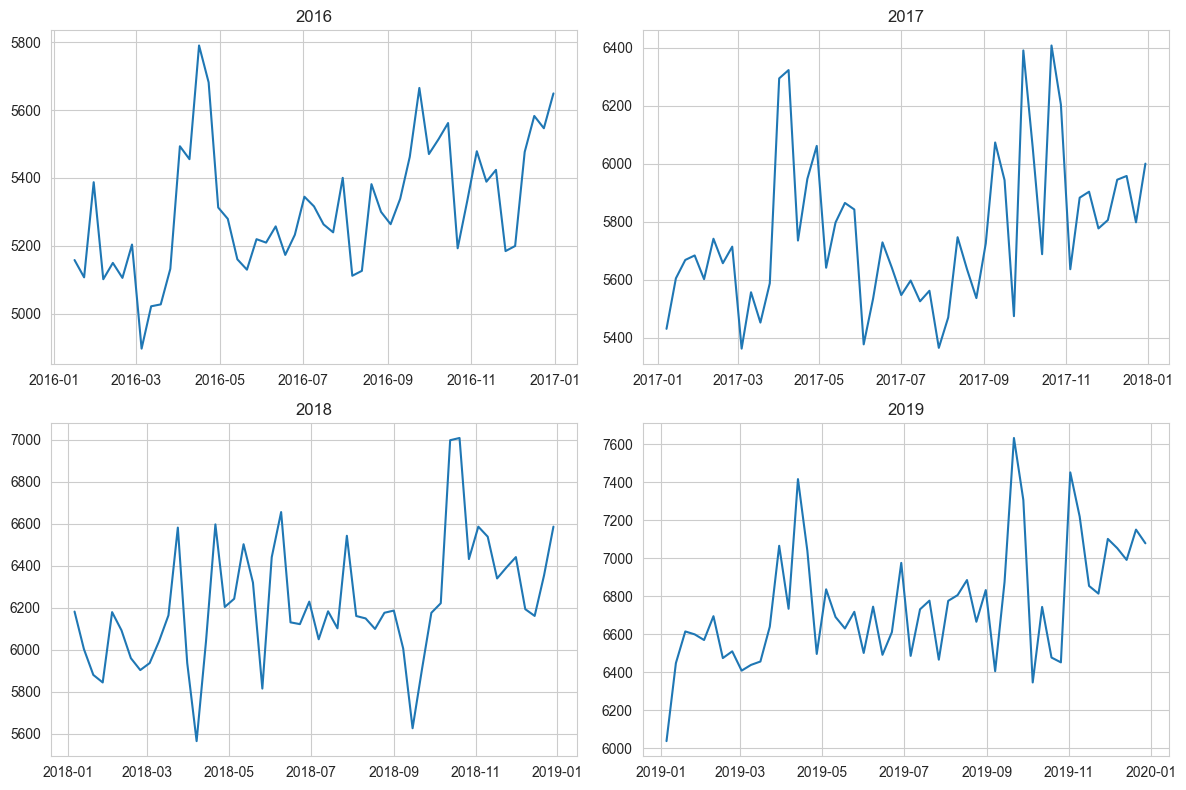

In [6]:
# Create subplots for each year
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()  # Flatten the array for easier iteration

# Loop over the years and plot data
for i, year in enumerate(range(2016, 2020)):
    data = weekly_data[weekly_data.index.year == year]
    axs[i].plot(data.index, data['Total credit card purchases in millions of shekels'])
    axs[i].set_title(str(year))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

The Hebrew calendar is 355 days long and every four years there is a leap year in which an additional month is added, making it 385 days. In a leap year, Passover occurs in May rather than April. It can be observed that 2018 was a leap year because there is no local maximum point in April, but there is one in May. From the tests we conducted for data not converted to the Hebrew date, we received significant partial autocorrelation for lags 1 to 60. In order to avoid this, we will attempt to transition to using the Hebrew date. Therefore, in order for the model to run well, we will switch to the Hebrew calendar.


In [7]:
from convertdate import hebrew

def gregorian_to_hebrew(timestamp):
    year, month, day = timestamp.year, timestamp.month, timestamp.day
    hebrew_date = hebrew.from_gregorian(year, month, day)
    return f'{hebrew_date[0]}-{hebrew_date[1]:02d}-{hebrew_date[2]:02d}'


weekly_data.index = weekly_data.index.map(gregorian_to_hebrew)
weekly_data = weekly_data.reset_index()
weekly_data.rename(columns={'index': 'date'}, inplace=True)


In [8]:
weekly_data['year'] = weekly_data['date'].apply(lambda x: int(x.split('-')[0])) #extract year
weekly_data['month'] = weekly_data['date'].apply(lambda x: int(x.split('-')[1]))  # Extract month


In [9]:
def is_hebrew_leap_year(year):
    return (year * 7 + 1) % 19 < 7

years_list = list({year for year in weekly_data['year']})
for year in years_list:
  print(f"Hebrew year {year} is a leap year: {is_hebrew_leap_year(year)}")

Hebrew year 5776 is a leap year: True
Hebrew year 5777 is a leap year: False
Hebrew year 5778 is a leap year: False
Hebrew year 5779 is a leap year: True
Hebrew year 5780 is a leap year: False


In [10]:
def correct_hebrew_year_transition(df):
    corrected_year = df['year'].iloc[0]
    for i in range(1, len(df)):
        current_year = df['year'].iloc[i]
        previous_month = df['month'].iloc[i-1]
        current_month = df['month'].iloc[i]

        if is_hebrew_leap_year(current_year):
            if current_month == 1 and previous_month == 13:
                corrected_year += 1
        else:
            if current_month == 1 and previous_month == 12:
                corrected_year += 1

        df.at[i, 'year'] = corrected_year
    return df

weekly_data = correct_hebrew_year_transition(weekly_data)


In [11]:
weekly_data.to_excel('jewish_calander.xlsx', index=False)

In [12]:
# Hebrew month names mapping
hebrew_months_regular = {
    '01': 'ירשת', '02': 'ןוושח', '03': 'ולסכ', '04': 'תבט',
    '05': 'טבש', '06': 'רדא', '07': 'ןסינ', '08': 'רייא',
    '09': 'ןויס', '10': 'זומת', '11': 'בא', '12': 'לולא'
}

hebrew_months_leap = {
    '01': 'ירשת', '02': 'ןוושח', '03': 'ולסכ', '04': 'תבט',
    '05': 'טבש', '06': 'א רדא', '07': 'רדא ב', '08': 'ןסינ',
    '09': 'רייא', '10': 'ןויס', '11': 'זומת', '12': 'בא', '13': 'לולא'
}

In [13]:
hebrew_months_leap = {
    '01': 'Nissan', '02': 'Iyar', '03': 'Sivan',
    '04': 'Tammuz', '05': 'Av', '06': 'Elul',
    '07': 'Tishrei', '08': 'Cheshvan', '09': 'Kislev',
    '10': 'Tevet', '11': 'Shvat', '12': 'Adar',
    '13': 'Adar II'
}

hebrew_months_regular = {
    '01': 'Nissan', '02': 'Iyar', '03': 'Sivan',
    '04': 'Tammuz', '05': 'Av', '06': 'Elul',
    '07': 'Tishrei', '08': 'Cheshvan', '09': 'Kislev',
    '10': 'Tevet', '11': 'Shvat', '12': 'Adar',
}

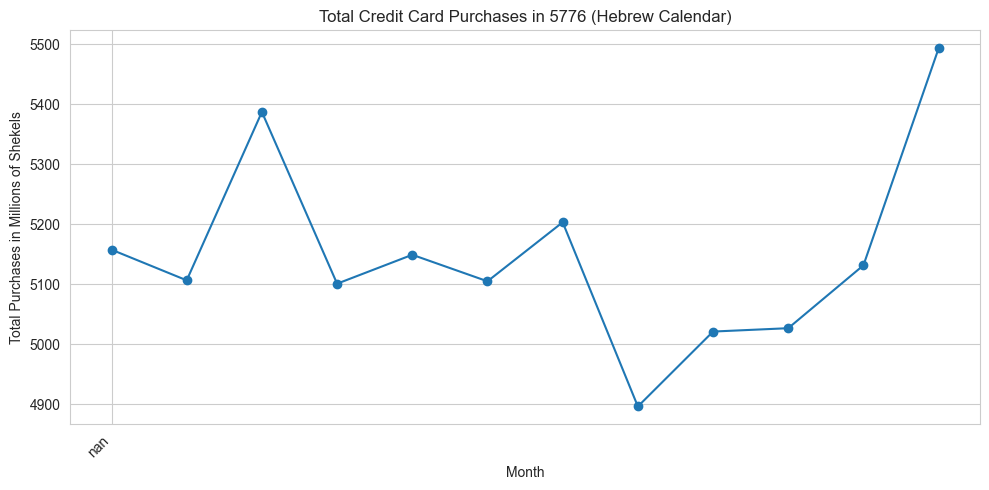

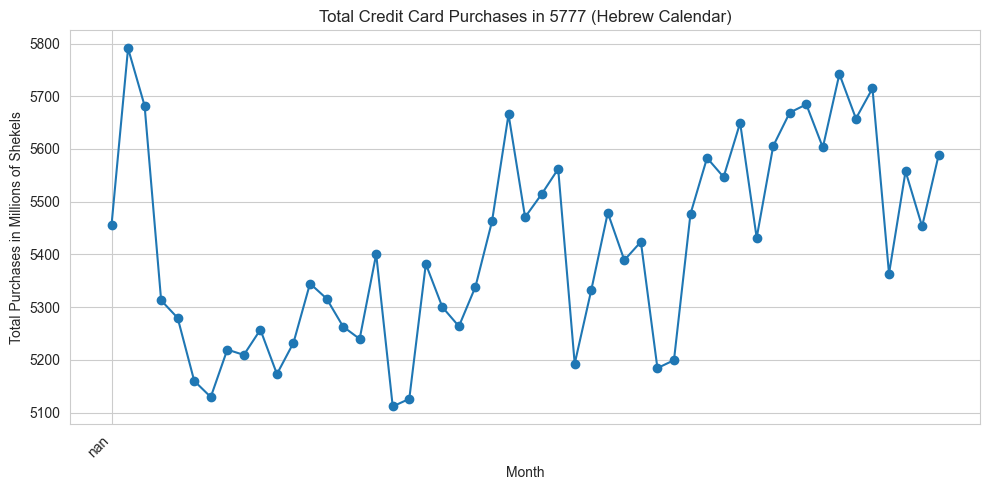

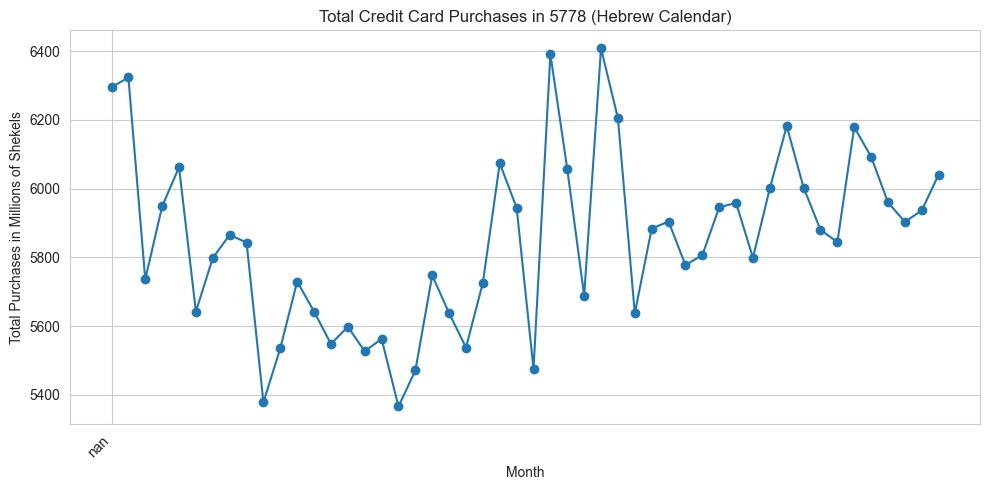

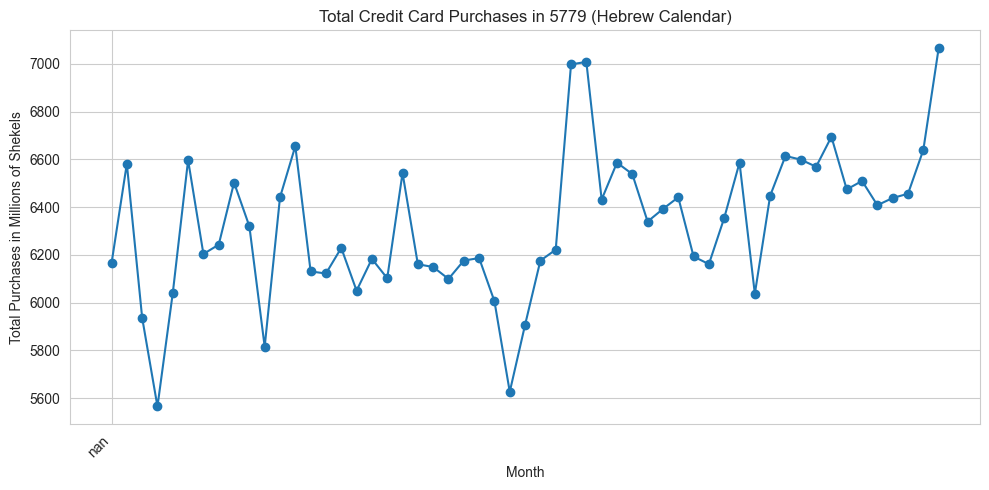

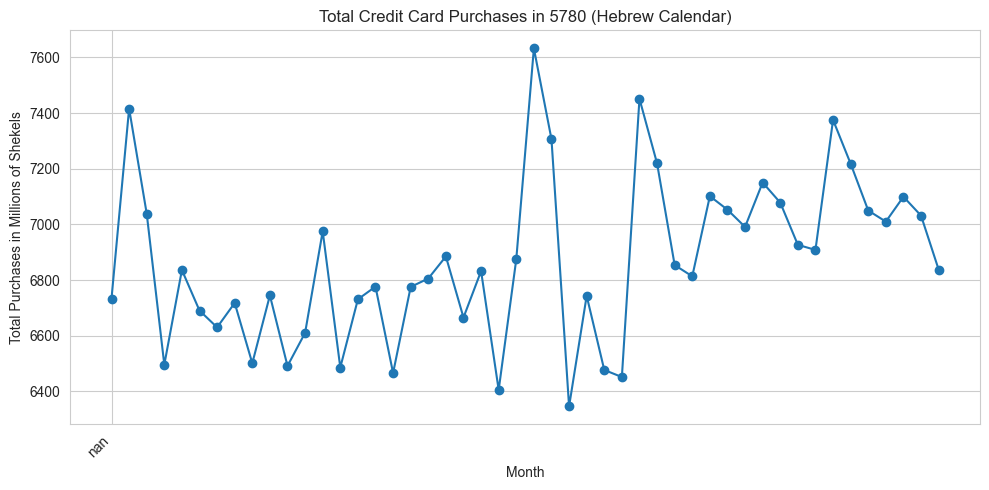

In [14]:
leap_years = {'5776', '5779'}

# Determine if a year is a leap year
def is_leap_year(year):
    return year in leap_years

# Plotting setup for each year
for year in weekly_data['year'].unique():
    data_for_year = weekly_data[weekly_data['year'] == year]
    data_for_year = data_for_year.sort_values('date')

    # Determine the month mapping to use based on leap year
    month_mapping = hebrew_months_leap if is_leap_year(year) else hebrew_months_regular
    data_for_year['month_name'] = data_for_year['month'].map(month_mapping)

    # Find the unique, first occurrence of each month to use as x-ticks
    unique_months = data_for_year.drop_duplicates('month_name', keep='first')

    plt.figure(figsize=(10, 5))
    plt.plot(data_for_year['date'], data_for_year['Total credit card purchases in millions of shekels'], marker='o')
    plt.title(f'Total Credit Card Purchases in {year} (Hebrew Calendar)')
    plt.xlabel('Month')
    plt.ylabel('Total Purchases in Millions of Shekels')
    plt.grid(True)

    # Set x-ticks at the positions of the first occurrence of each month
    plt.xticks(unique_months['date'], unique_months['month_name'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

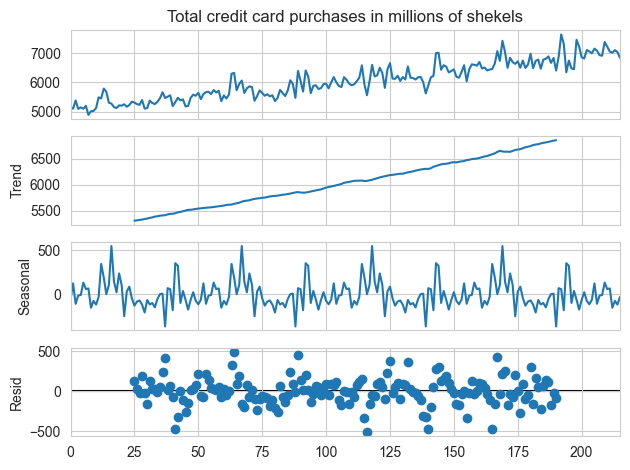

In [15]:
decomposition=seasonal_decompose(weekly_data['Total credit card purchases in millions of shekels'],model='additive',period=51)
decomposition.plot()
plt.show()

In [16]:
data_diff=weekly_data['Total credit card purchases in millions of shekels'].diff(periods=51)
# the number is 51 since in the hebrew calander there are 51 weeks

dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.28540979412886
2. P-Value :  0.00047077704834336183
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 155
5. Critical Values :
	 1% :  -3.4732590518613002
	 5% :  -2.880374082105334
	 10% :  -2.5768120811654525


# Part 2 - Model Fitting

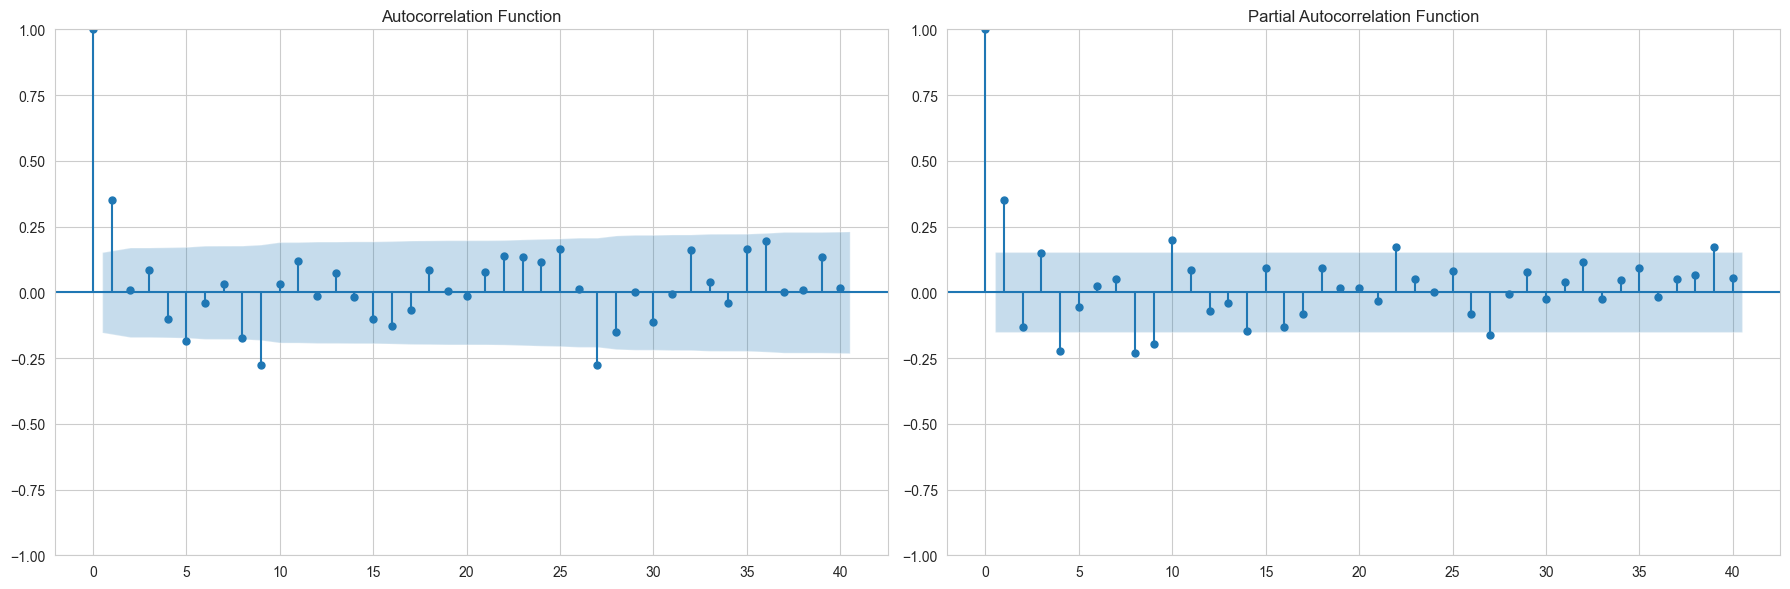

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Remove NaN values to ensure the functions work properly
data_diff_nonan = data_diff.dropna()

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the Autocorrelation Function (ACF)
plot_acf(data_diff_nonan, lags=40, alpha=0.05, ax=axes[0])  # Using 40 lags and 95% confidence interval
axes[0].set_title('Autocorrelation Function')

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(data_diff_nonan, lags=40, alpha=0.05, method='ywm', ax=axes[1])  # Yule-Walker with bias correction
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Thus, based on these results, the time series appears to be stationary, meaning it does not have a unit root, and shows properties such as constant mean and variance over time.

diffrentiare by one year.

In [18]:
weekly_data = weekly_data.set_index('date')

In [19]:
weekly_data = weekly_data.drop(['year'], axis=1)
weekly_data = weekly_data.drop(['month'], axis=1)
weekly_data

,Total credit card purchases in millions of shekels
date,
5776-11-06,5157.9
5776-11-13,5106.8
5776-11-20,5387.5
5776-11-27,5101.2
5776-12-04,5149.4
...,...
5780-11-06,7049.9
5780-11-13,7010.1
5780-11-20,7099.6


In [20]:
weekly_data.rename(columns={'Total credit card purchases in millions of shekels': 'purches'}, inplace=True)


The plot's baseline hovering around a higher value (e.g., around 500) indicates that the data, after this operation, still exhibits a trend or a shift from the original baseline (zero in case of seasonality plots). This shift could be due to the nature of the differences calculated, where if the dataset originally had a growing or declining trend, the differences could reflect this trend not as a fluctuation around zero but shifted upwards or downwards.

the first spike in both of the graphs hints AR(1) and MA(1)
moreover D=1 and d=51

C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Value

                               SARIMAX Results                                
Dep. Variable:                purches   No. Observations:                  216
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1501.554
Date:                Sun, 08 Sep 2024   AIC                           3011.107
Time:                        19:11:49   BIC                           3024.608
Sample:                             0   HQIC                          3016.562
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6056.9428    652.021      9.289      0.000    4779.005    7334.880
ar.L1          0.9958      0.009    110.357      0.000       0.978       1.013
ma.L1         -0.7168      0.042    -16.996      0.0

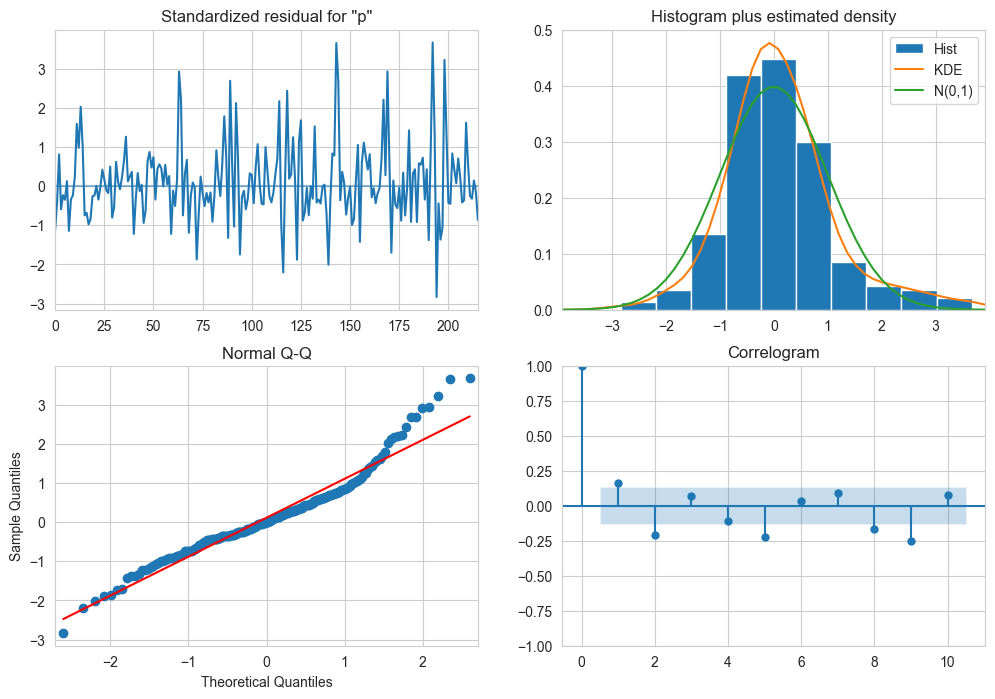

In [21]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit an ARMA(1,1) model
ARMA11 = ARIMA(weekly_data, order=(1, 0, 1))  # Here (1, 0, 1) represents ARMA(1,1) with no differencing
results_ARMA11 = ARMA11.fit()

# Print the summary of the model results
print(results_ARMA11.summary())

# Optional: Plot the diagnostics to check for any unusual behavior
results_ARMA11.plot_diagnostics(figsize=(12, 8))
plt.show()

C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Value

                                      SARIMAX Results                                      
Dep. Variable:                             purches   No. Observations:                  216
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 51)   Log Likelihood               -1173.516
Date:                             Sun, 08 Sep 2024   AIC                           2353.032
Time:                                     19:13:03   BIC                           2362.314
Sample:                                          0   HQIC                          2356.800
                                             - 216                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9404      0.026     35.512      0.000       0.889       0.992
ma.L1         -0.4780      

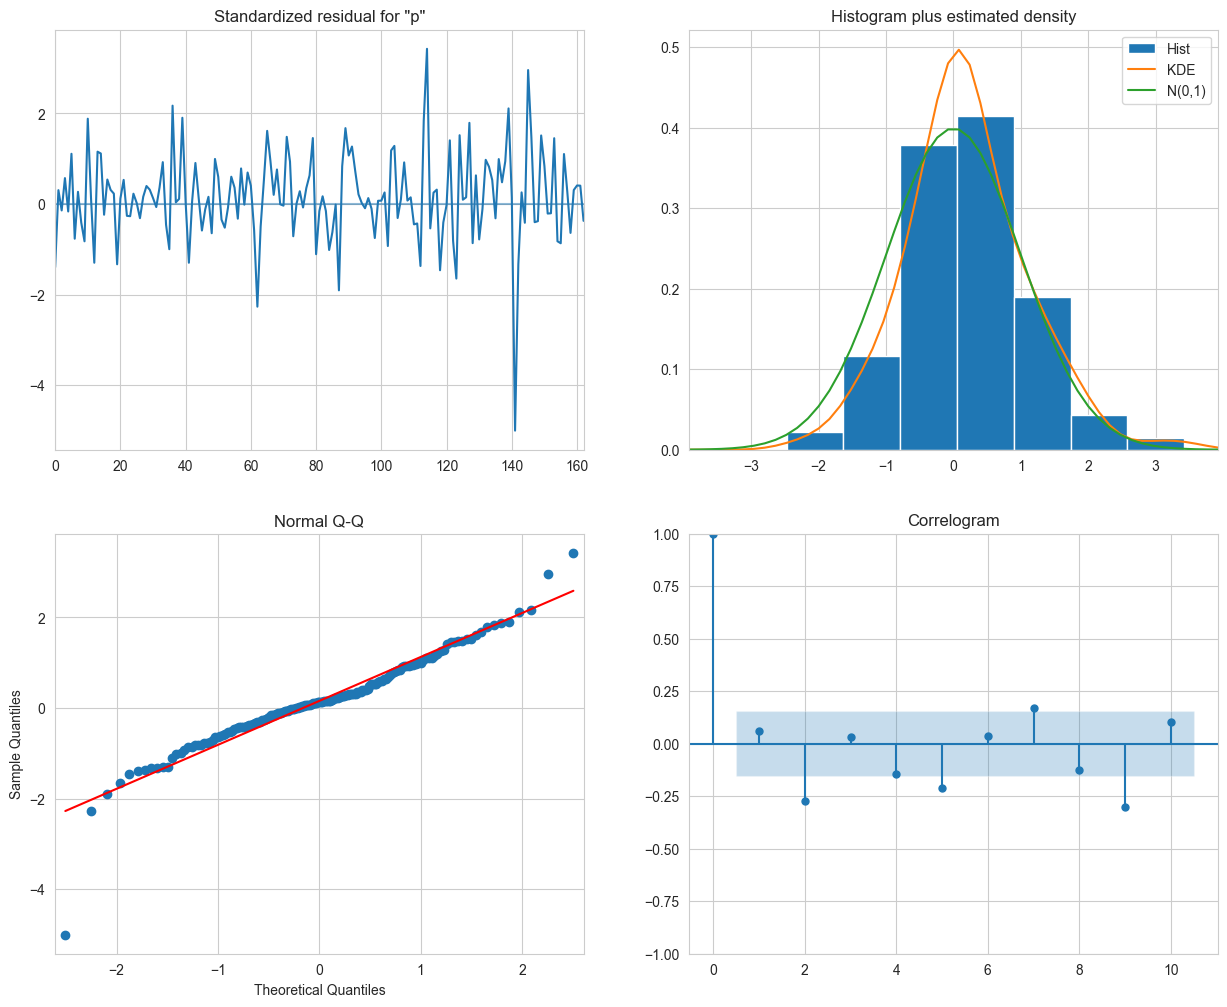

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Example SARIMA model on the data_diff_nonan dataset
SARIMA_D1 = SARIMAX(weekly_data,
                order=(1, 0, 1),
                seasonal_order=(0, 1, 0, 51),  # Seasonal period is 51
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
SARIMA_D1_results = SARIMA_D1.fit()

# Print the summary of the model
print(SARIMA_D1_results.summary())

# Optional: Plot diagnostics to check for any unusual behavior
SARIMA_D1_results.plot_diagnostics(figsize=(15, 12))
plt.show()


C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Value

                                      SARIMAX Results                                      
Dep. Variable:                             purches   No. Observations:                  216
Model:             SARIMAX(1, 0, 1)x(0, 2, [], 51)   Log Likelihood                -841.638
Date:                             Sun, 08 Sep 2024   AIC                           1689.276
Time:                                     19:13:49   BIC                           1697.432
Sample:                                          0   HQIC                          1692.585
                                             - 216                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1333      0.214      0.623      0.534      -0.286       0.553
ma.L1          0.3929      

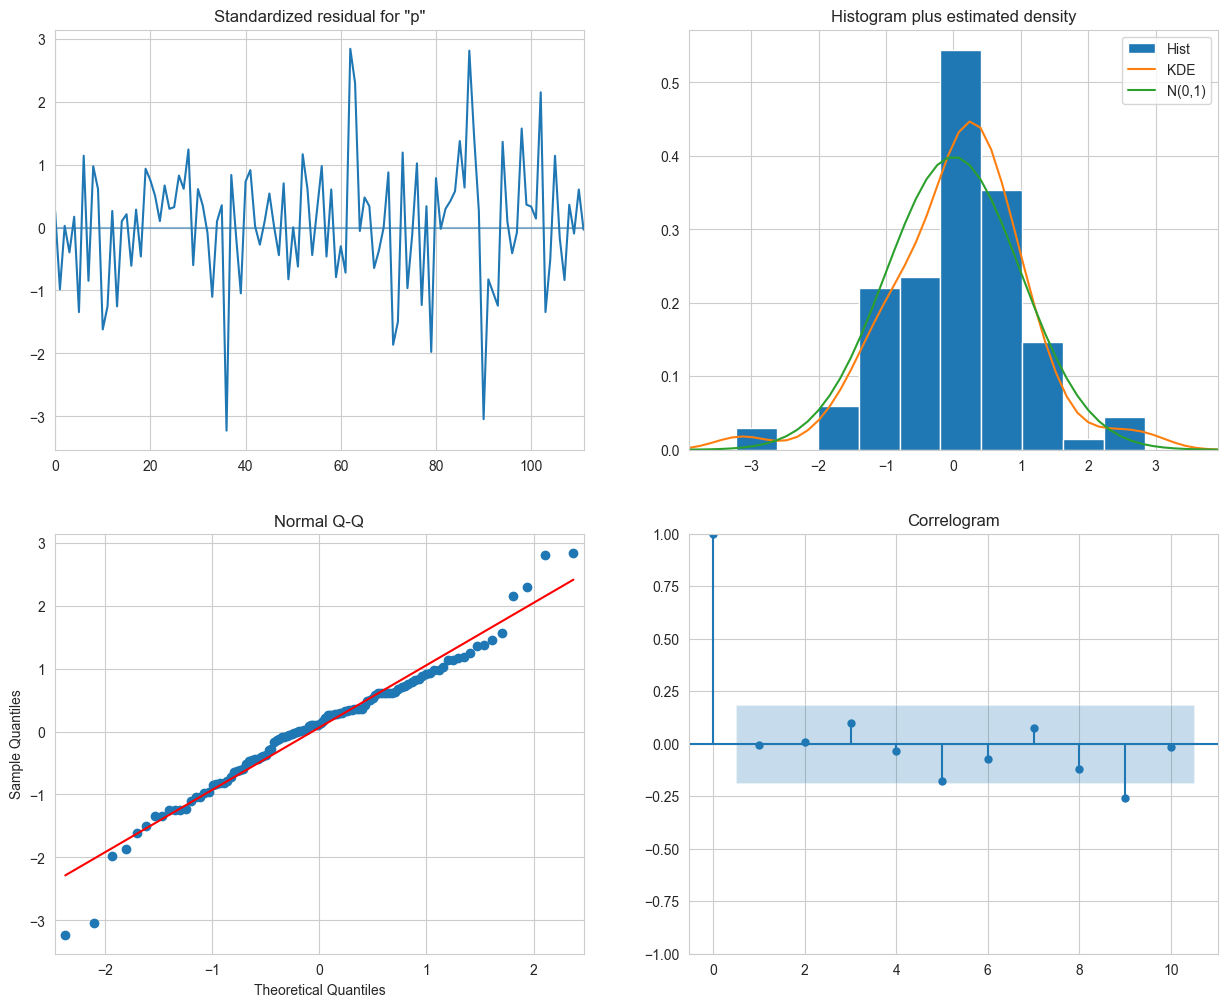

In [23]:

# Example SARIMA model on the data_diff_nonan dataset
SARIMAD2 = SARIMAX(weekly_data,
                order=(1, 0, 1),
                seasonal_order=(0, 2, 0, 51),  # Seasonal period is 51
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
SARIMAD2_results = SARIMAD2.fit()

# Print the summary of the model
print(SARIMAD2_results.summary())

# Optional: Plot diagnostics to check for any unusual behavior
SARIMAD2_results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
# Number of periods to forecast
forecast_steps = 25

# Forecast using each model
forecast_ARMA11 = results_ARMA11.get_forecast(steps=forecast_steps).predicted_mean
forecast_SARIMA_D1 = SARIMA_D1_results.get_forecast(steps=forecast_steps).predicted_mean
forecast_SARIMA_D2 = SARIMAD2_results.get_forecast(steps=forecast_steps).predicted_mean

# Combine forecasts into a single DataFrame
forecast_df = pd.DataFrame({
    'Historical Data': weekly_data['purches'],
    'Forecast_ARMA11': forecast_ARMA11,
    'Forecast_SARIMA_D1': forecast_SARIMA_D1,
    'Forecast_SARIMA_D2': forecast_SARIMA_D2,
})


C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\orco\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction re

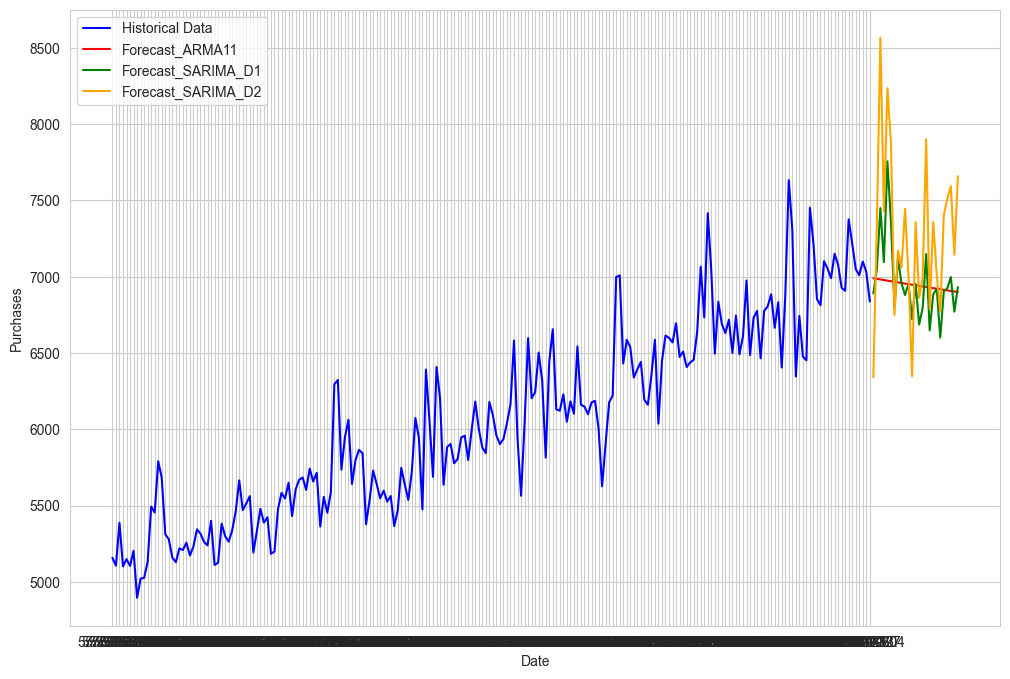

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(weekly_data.index, weekly_data['purches'], label='Historical Data', color='blue')
plt.plot(forecast_ARMA11.index, forecast_ARMA11, label='Forecast_ARMA11', color='red')
plt.plot(forecast_SARIMA_D1.index, forecast_SARIMA_D1, label='Forecast_SARIMA_D1', color='green')
plt.plot(forecast_SARIMA_D2.index, forecast_SARIMA_D2, label='Forecast_SARIMA_D2', color='orange')

# Customize the x-axis to show only one mark per year
#plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=len(weekly_data.index.year.unique())))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(weekly_data.index.year.unique()))

plt.xlabel('Date')
plt.ylabel('Purchases')
plt.legend()
plt.show()


## Prophet

In [26]:
#file_path = '/content/drive/My Drive/project data.csv'
file_path = 'project data.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
weekly_data = df.resample('W-SAT').sum() # Resample the data by week. 'W-SAT' means weeks ending on Saturday.
weekly_data = weekly_data.iloc[1:]  # Remove the first row if it does not represent a complete week
cutoff_date = pd.Timestamp('2020-03-01')# Set cutoff date to remove empty data entries after this point
weekly_data = weekly_data[weekly_data.index < cutoff_date]
weekly_data.rename(columns={'Total credit card purchases in millions of shekels': 'purches'}, inplace=True)

# Prepare the data for Prophet
weekly_data.reset_index(inplace=True)
prophet_data = weekly_data.rename(columns={'date': 'ds', 'purches': 'y'})[['ds', 'y']]


In [27]:
model = Prophet()
model.add_country_holidays(country_name='IL')
model.fit(prophet_data)


19:13:50 - cmdstanpy - INFO - Chain [1] start processing
19:13:50 - cmdstanpy - INFO - Chain [1] done processing


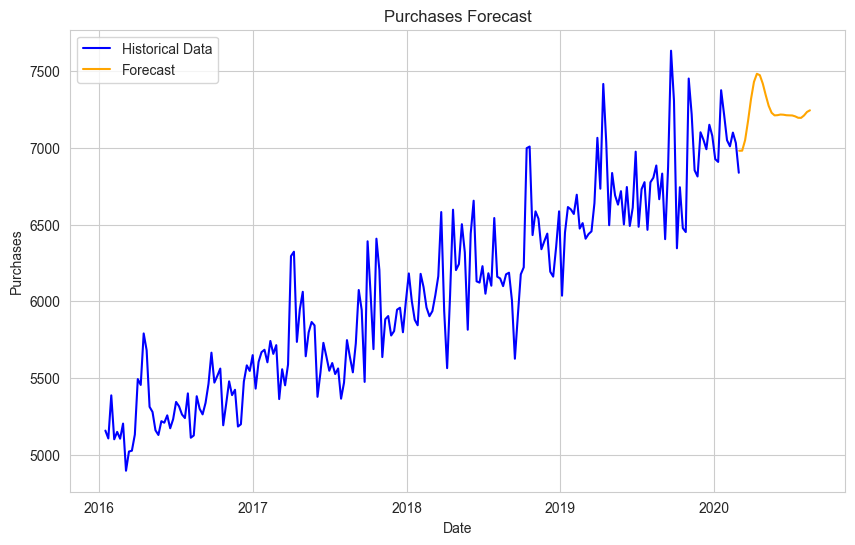

In [28]:
# Create a DataFrame with future dates
future_dates = model.make_future_dataframe(periods=25, freq='W')

# Make predictions
forecast = model.predict(future_dates)

# Plot the historical data and the forecast starting from the last date of the original data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prophet_data['ds'], prophet_data['y'], label='Historical Data', color='blue')

# Filter the forecast to start from the last date of the original data
last_date = prophet_data['ds'].max()
forecast_filtered = forecast[forecast['ds'] > last_date]

ax.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Forecast', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Purchases')
ax.set_title('Purchases Forecast')
ax.legend()
plt.show()


## All models on the same plot


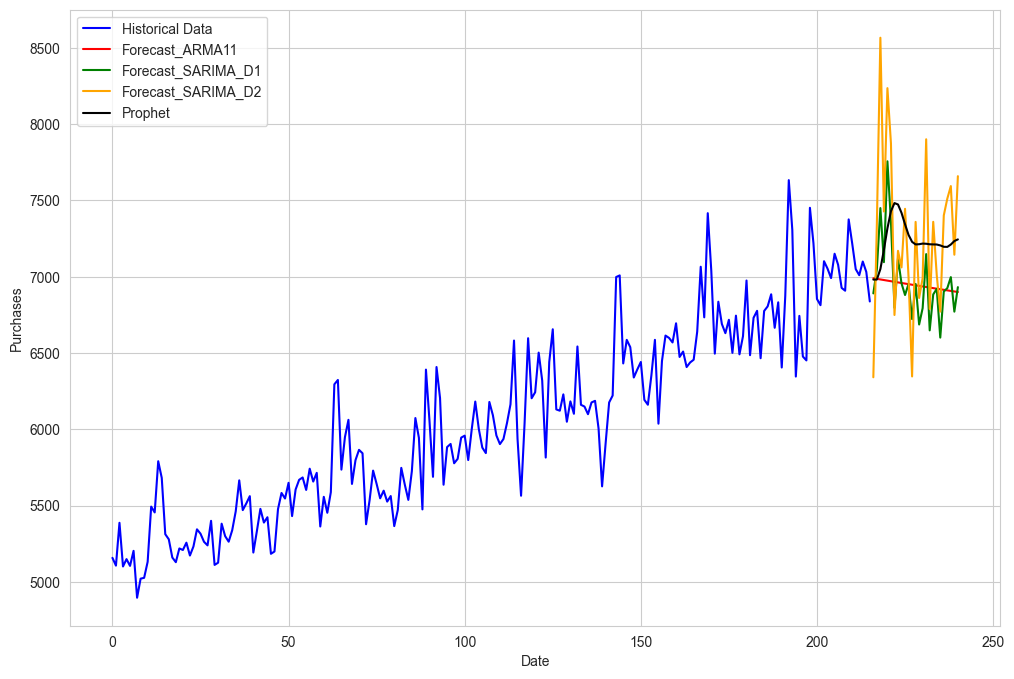

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(weekly_data.index, weekly_data['purches'], label='Historical Data', color='blue')
plt.plot(forecast_ARMA11.index, forecast_ARMA11, label='Forecast_ARMA11', color='red')
plt.plot(forecast_SARIMA_D1.index, forecast_SARIMA_D1, label='Forecast_SARIMA_D1', color='green')
plt.plot(forecast_SARIMA_D2.index, forecast_SARIMA_D2, label='Forecast_SARIMA_D2', color='orange')


plt.plot(forecast_filtered.index, forecast_filtered['yhat'], label='Prophet', color='black')
plt.xlabel('Date')
plt.ylabel('Purchases')
plt.legend()
plt.show()


# Part 3 - Incorporating an Exogenous Variable

The variable we chose to incorporate is the GDP of Israel over time. After consulting with experts in the field, we realized that GDP is the most influential variable we can use. As GDP rises, people earn more money and consequently spend more. However, GDP cannot be used directly for state modeling since it is collected after the purchase data. Another issue is that the data is available quarterly, not weekly like our original data. To address this, we assumed the trend is linear within each quarter and calculated weekly values based on this assumption.

## Preprocess 

In [30]:
df = pd.read_csv("project data.csv")

In [31]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
weekly_data = df.resample('W-SAT').sum() # Resample the data by week. 'W-SAT' means weeks ending on Saturday.
weekly_data = weekly_data.iloc[1:]  # Remove the first row if it does not represent a complete week
cutoff_date = pd.Timestamp('2019-12-29')# Set cutoff date to remove empty data entries after this point
weekly_data = weekly_data[weekly_data.index < cutoff_date]
weekly_data

,Total credit card purchases in millions of shekels
date,
2016-01-16,5157.9
2016-01-23,5106.8
2016-01-30,5387.5
2016-02-06,5101.2
2016-02-13,5149.4
...,...
2019-11-30,7101.6
2019-12-07,7052.9
2019-12-14,6991.1


In [32]:
gdp_data = pd.read_csv("GDP_data.csv")

In [33]:
gdp_data['year'] = gdp_data['time period'].apply(lambda x: int(x.split("-")[0]))
gdp_data['quarter'] = gdp_data['time period'].apply(lambda x: x.split("-")[1])
gdp_data = gdp_data[gdp_data['year'] >= 2016]
gdp_data

,time period,amount,year,quarter
84,2016-Q1,"300,479.0",2016,Q1
85,2016-Q2,"304,061.5",2016,Q2
86,2016-Q3,"311,610.9",2016,Q3
87,2016-Q4,"316,518.1",2016,Q4
88,2017-Q1,"313,691.9",2017,Q1
89,2017-Q2,"318,316.3",2017,Q2
90,2017-Q3,"321,680.7",2017,Q3
91,2017-Q4,"332,174.6",2017,Q4
92,2018-Q1,"328,303.8",2018,Q1
93,2018-Q2,"331,689.5",2018,Q2


In [34]:
# Ensure the index is a DatetimeIndex
if not isinstance(weekly_data.index, pd.DatetimeIndex):
    weekly_data.index = pd.to_datetime(weekly_data.index)

In [35]:
weekly_data['quarter'] = weekly_data.index.to_period('Q').strftime('Q%q')

In [36]:
gdp_data['amount'] = gdp_data['amount'].str.replace(',', '').astype(float)
gdp_data.sort_index(inplace=True)

In [37]:
def interpolate_gdp(row):
    quarter = row['quarter']
    index = gdp_data[(gdp_data['quarter'] == quarter) & (gdp_data['year'] == row.name.year)].index[0]
    try:
        start_gdp = gdp_data.loc[index]['amount']
        end_gdp =  gdp_data.loc[index+1]['amount']
        weeks_in_quarter = 13
        weekly_diff = (end_gdp - start_gdp) / (weeks_in_quarter - 1) if weeks_in_quarter > 1 else 0
        return start_gdp + row.name.weekofyear * weekly_diff
    except Exception as e:
        return pd.NA

In [38]:
weekly_data['gdp'] = weekly_data.apply(interpolate_gdp, axis=1)

Text(0.5, 1.0, 'GDP Along Time')

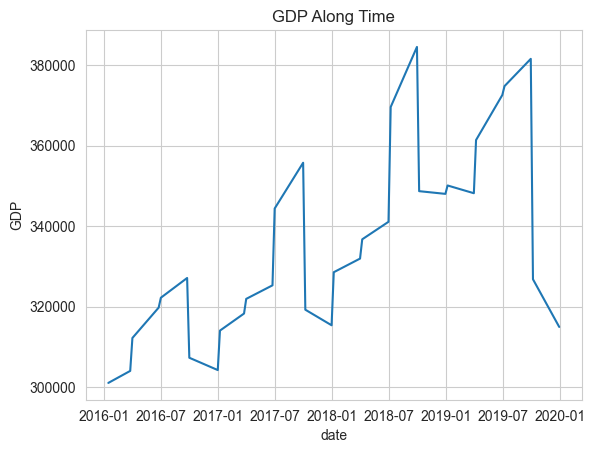

In [39]:
sns.lineplot(data=weekly_data, x='date', y='gdp')
plt.xlabel("date")
plt.ylabel("GDP")
plt.title("GDP Along Time")

## Visualization

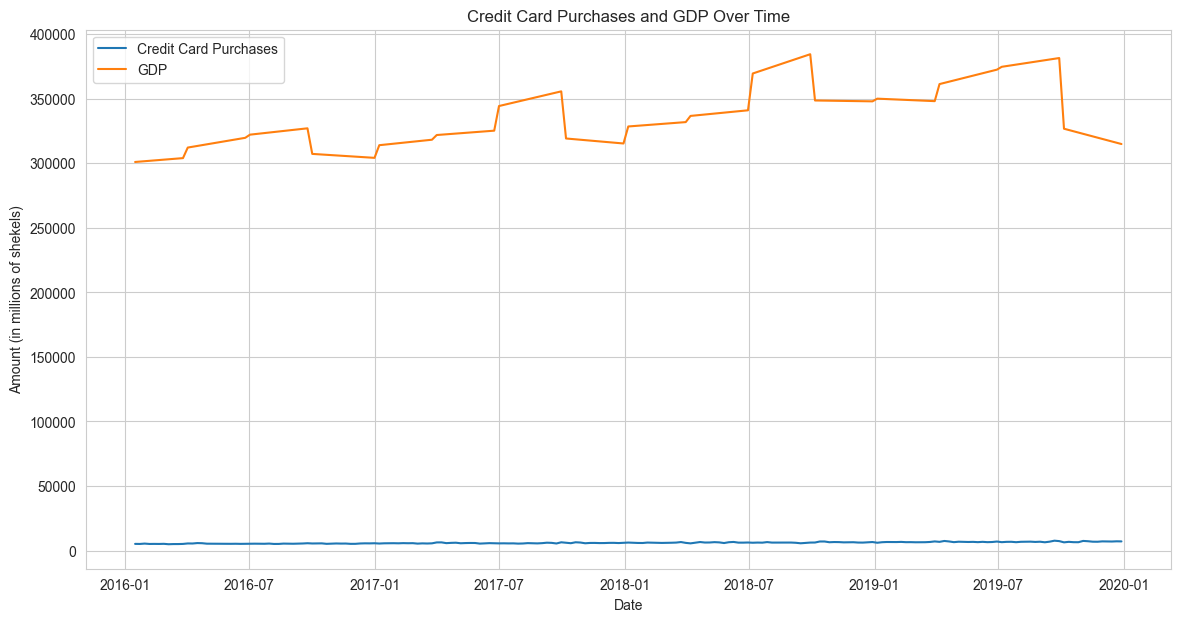

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(weekly_data.index, weekly_data['Total credit card purchases in millions of shekels'], label='Credit Card Purchases')
plt.plot(weekly_data.index, weekly_data['gdp'], label='GDP')
plt.legend()
plt.title('Credit Card Purchases and GDP Over Time')
plt.xlabel('Date')
plt.ylabel('Amount (in millions of shekels)')
plt.show()

As you can see, there are significant differences in the variables' scales. So let's standardize or normalize them for better visualization and modeling

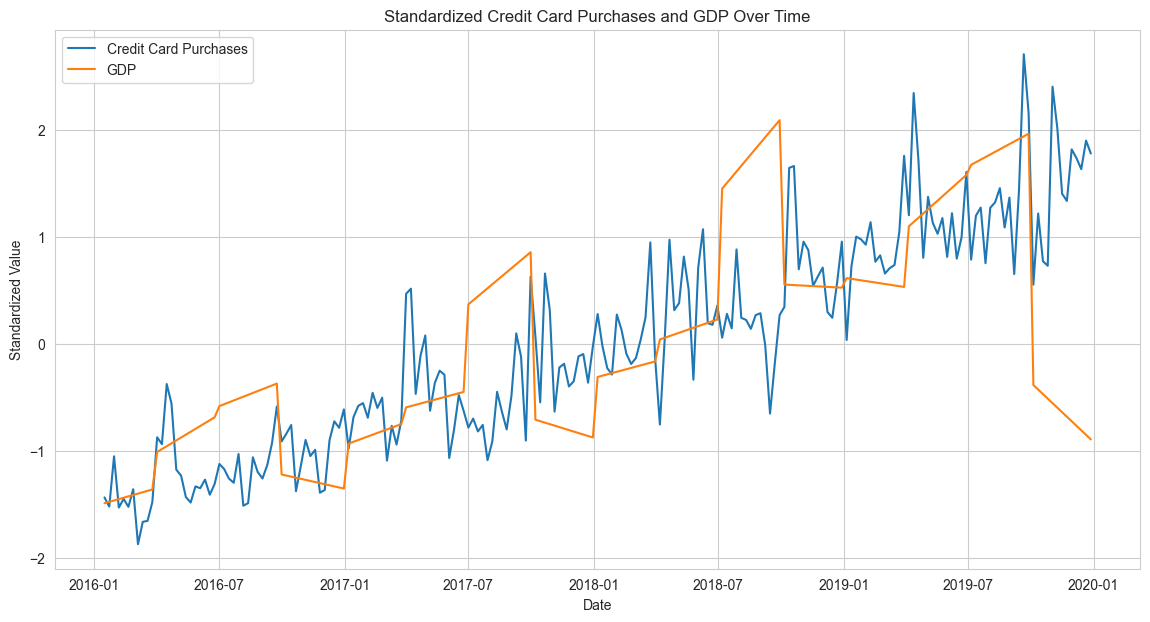

In [41]:
standard_scaler_df = weekly_data.copy()
scaler = StandardScaler()
standard_scaler_df[['Total credit card purchases in millions of shekels', 'gdp']] = scaler.fit_transform(
    standard_scaler_df[['Total credit card purchases in millions of shekels', 'gdp']]
)

# Plot the standardized data
plt.figure(figsize=(14, 7))
plt.plot(standard_scaler_df.index, standard_scaler_df['Total credit card purchases in millions of shekels'], label='Credit Card Purchases')
plt.plot(standard_scaler_df.index, standard_scaler_df['gdp'], label='GDP')
plt.legend()
plt.title('Standardized Credit Card Purchases and GDP Over Time')
plt.xlabel('Date')
plt.ylabel('Standardized Value')
plt.show()

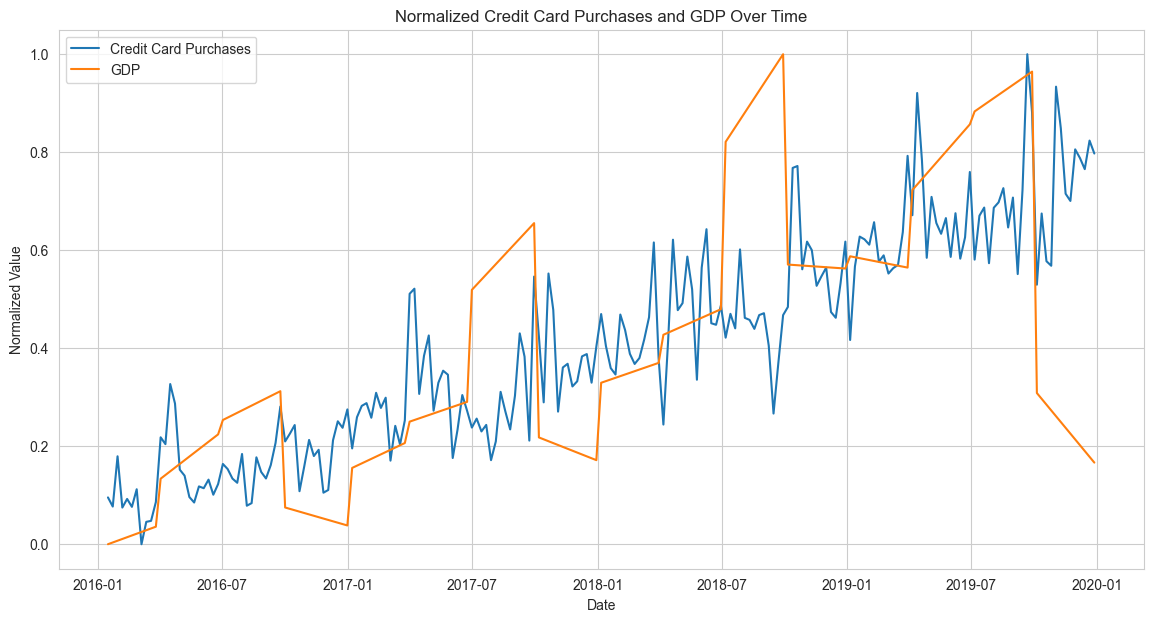

In [42]:
min_max_df = weekly_data.copy()

# Normalize the data
scaler = MinMaxScaler()
min_max_df[['Total credit card purchases in millions of shekels', 'gdp']] = scaler.fit_transform(
    min_max_df[['Total credit card purchases in millions of shekels', 'gdp']]
)

# Plot the normalized data
plt.figure(figsize=(14, 7))
plt.plot(min_max_df.index, min_max_df['Total credit card purchases in millions of shekels'], label='Credit Card Purchases')
plt.plot(min_max_df.index, min_max_df['gdp'], label='GDP')
plt.legend()
plt.title('Normalized Credit Card Purchases and GDP Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.show()


Overall, both methods worked well, and now we can both features on the same scale. Standard scaler is probably more suitable for our data, since it's used when we cannot assume a normal distribution, so we'll continue with this scaler. 
Let's visualize the connection between the two features:

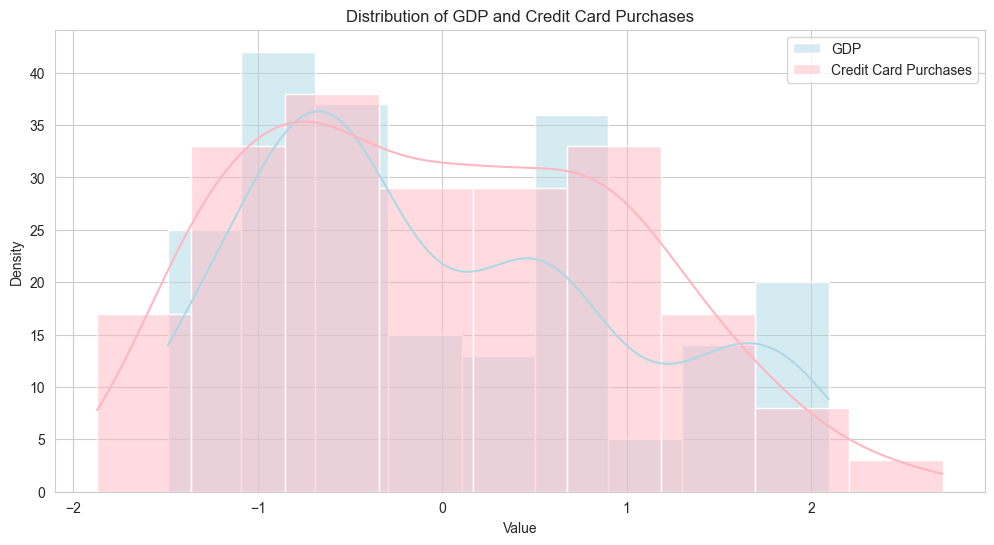

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(standard_scaler_df['gdp'], kde=True, color='lightblue', label='GDP')
sns.histplot(standard_scaler_df['Total credit card purchases in millions of shekels'], kde=True, color='lightpink', label='Credit Card Purchases')
plt.title('Distribution of GDP and Credit Card Purchases')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

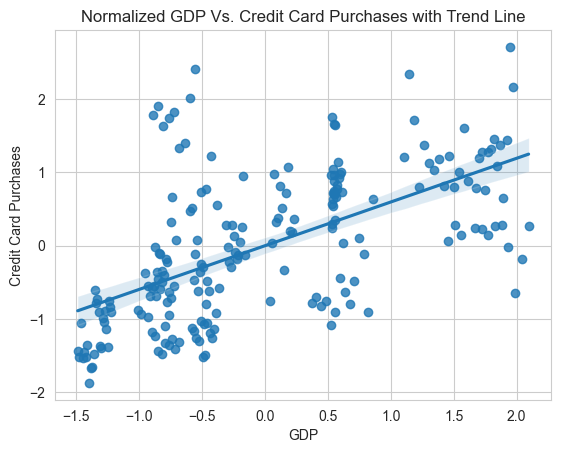

In [44]:
sns.regplot(data=standard_scaler_df, x='gdp', y='Total credit card purchases in millions of shekels')
plt.title('Normalized GDP Vs. Credit Card Purchases with Trend Line')
plt.xlabel('GDP')
plt.ylabel('Credit Card Purchases') 
plt.show()

The trend line in this scatter plot shows a positive trend, meaning that the amount of expenses increases as the GDP rises, as expected

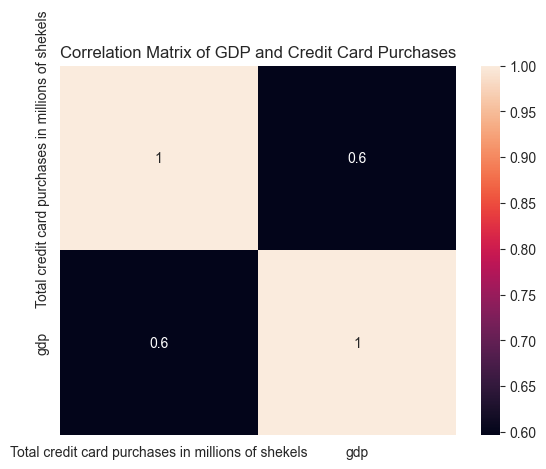

In [45]:
correlation_matrix = standard_scaler_df[['Total credit card purchases in millions of shekels', 'gdp']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of GDP and Credit Card Purchases')
plt.show()

Relatively high correlation between the variables. 

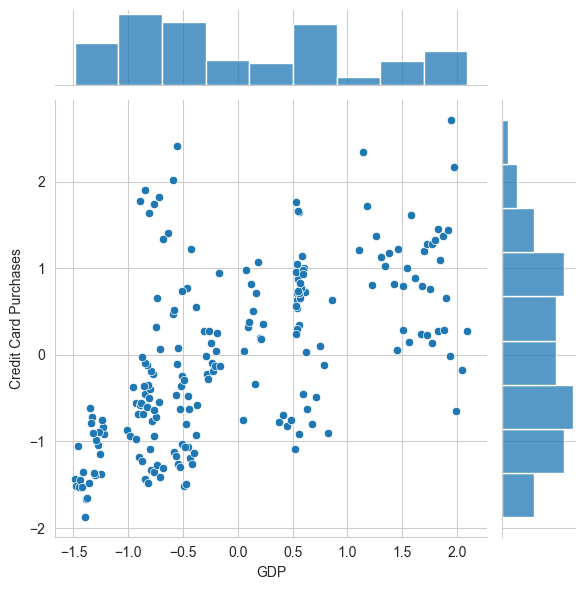

In [46]:
sns.jointplot(data=standard_scaler_df, x='gdp', y='Total credit card purchases in millions of shekels', kind='scatter')
plt.xlabel('GDP')
plt.ylabel('Credit Card Purchases')
plt.show()

## Differentiation

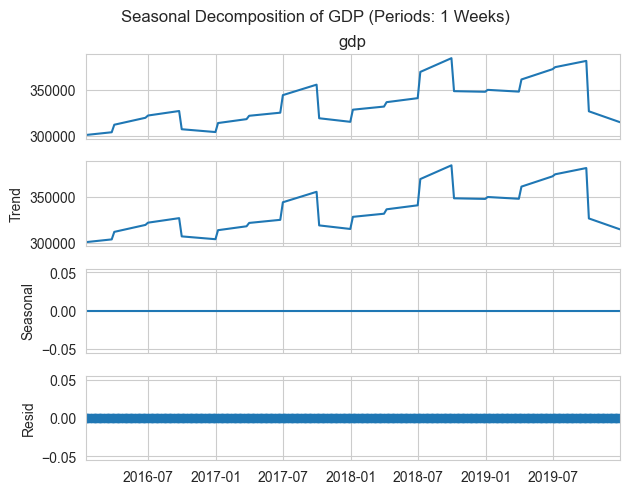

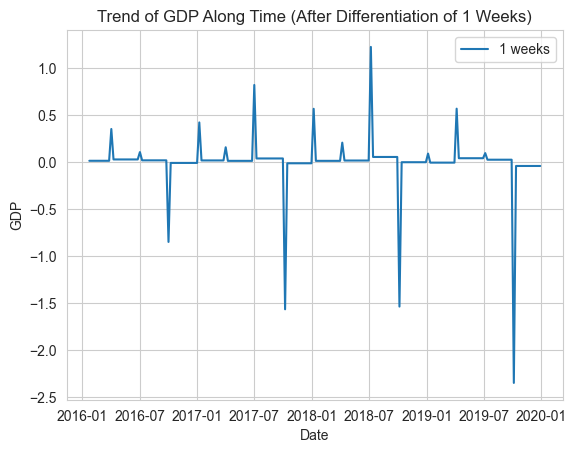

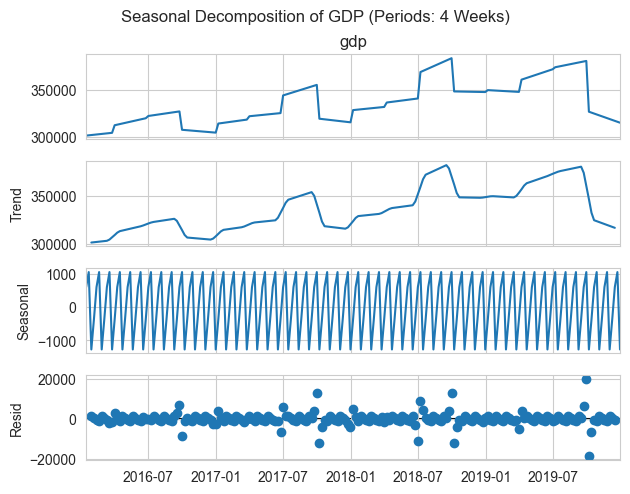

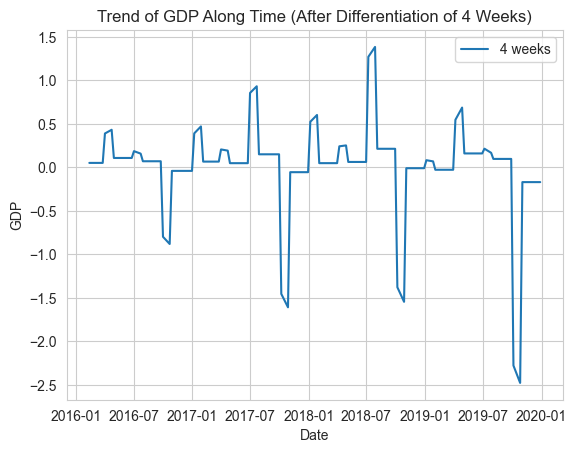

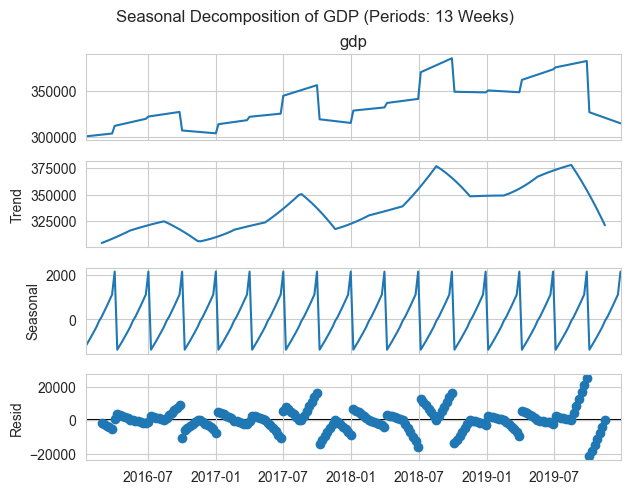

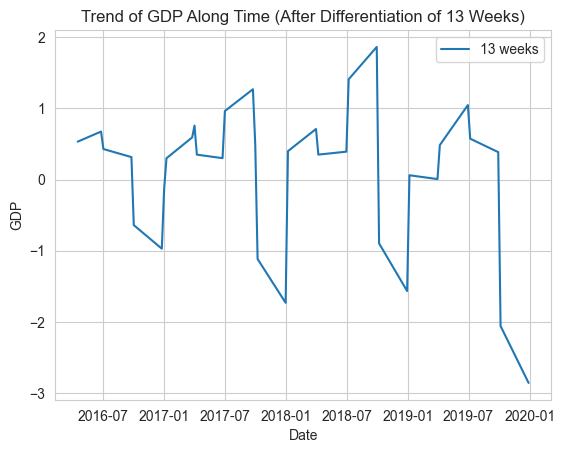

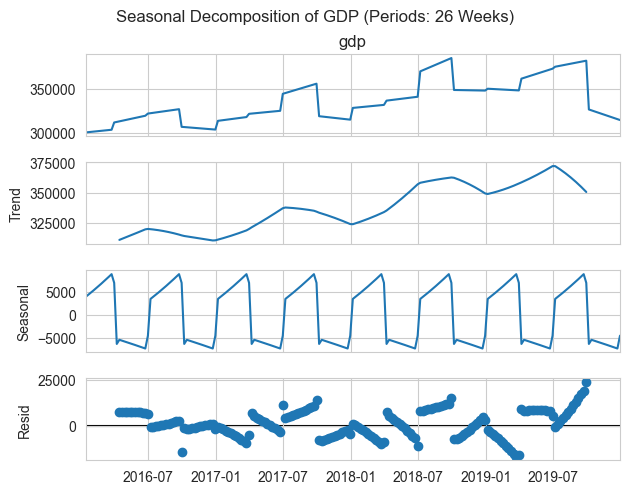

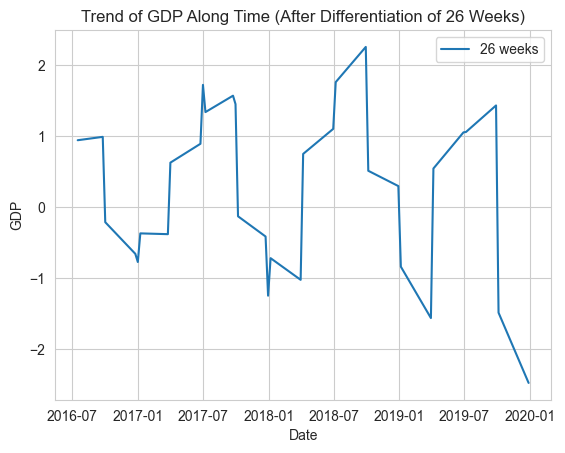

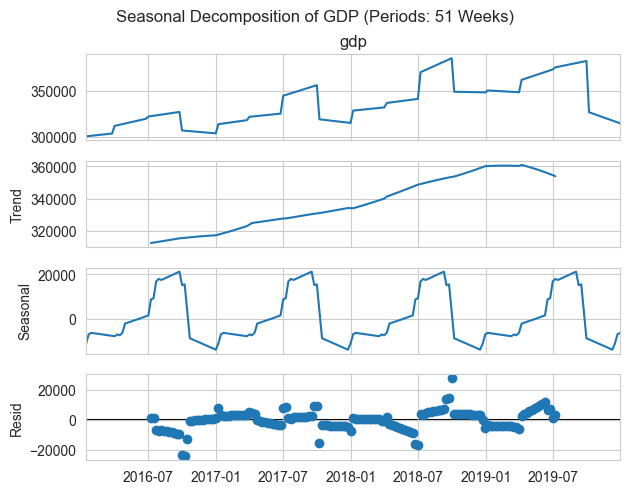

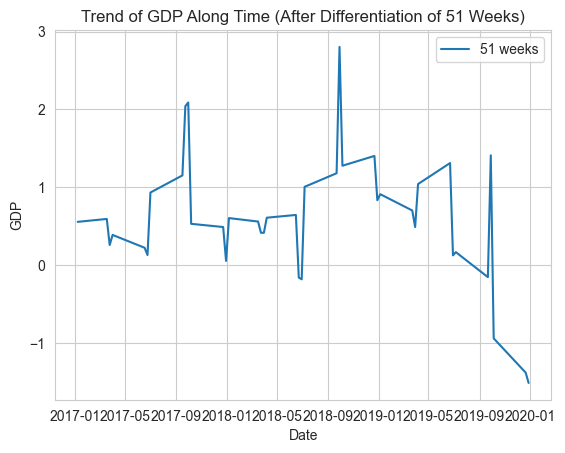

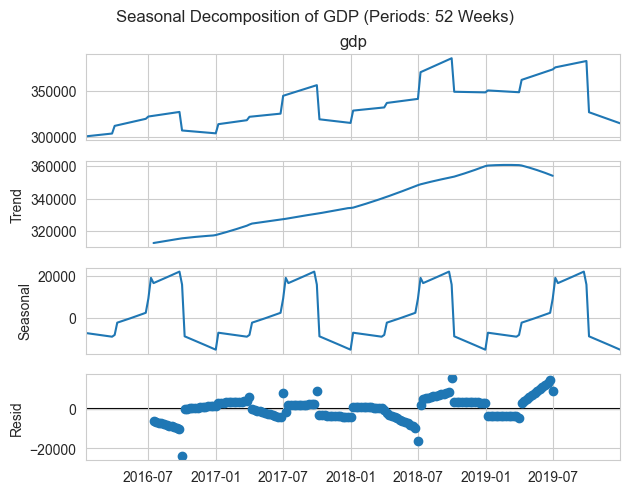

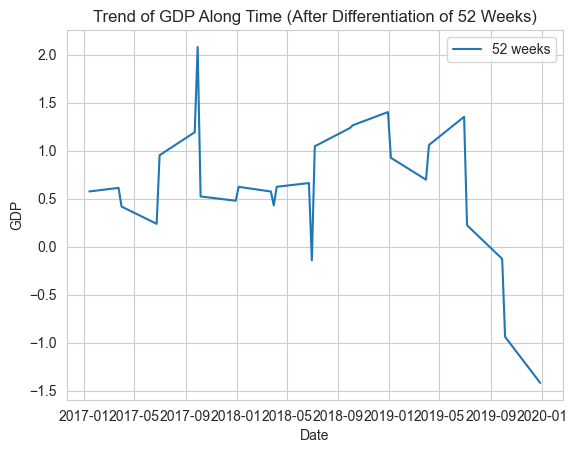

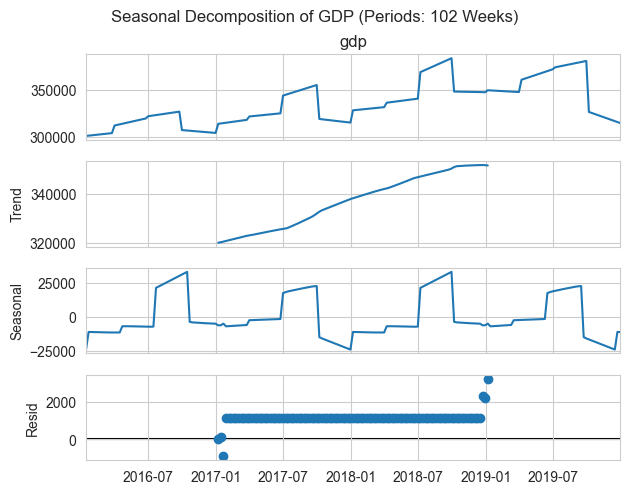

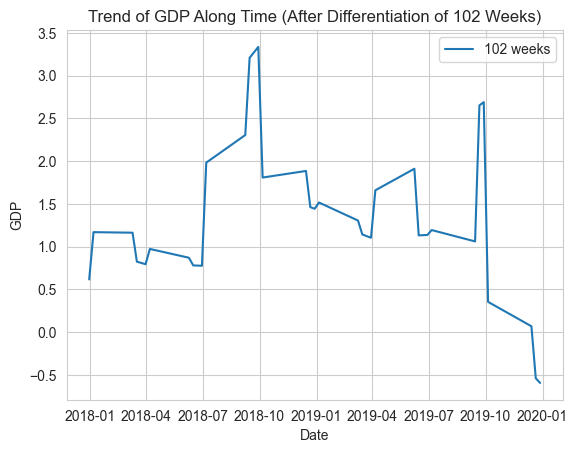

In [47]:
weeks_num = [1, 4, 13, 26, 51, 52, 102]
for week in weeks_num:
    decomposition=seasonal_decompose(weekly_data['gdp'], model='additive', period=week)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition of GDP (Periods: {week} Weeks)", y=1.02)
    plt.show()
    data_diff = standard_scaler_df['gdp'].diff(periods=week)
    plt.plot(data_diff.index, data_diff, label=f'{week} weeks')
    plt.legend()
    plt.title(f'Trend of GDP Along Time (After Differentiation of {week} Weeks)')
    plt.xlabel('Date')
    plt.ylabel('GDP')
    plt.show()

In [48]:
standard_scaler_df['diff_credit_card_purchases'] = standard_scaler_df['Total credit card purchases in millions of shekels'].diff(periods=51).dropna()
standard_scaler_df['diff_gdp'] = standard_scaler_df['gdp'].diff(periods=51).dropna()
data = standard_scaler_df[['diff_credit_card_purchases', 'diff_gdp']].dropna()

## Model

                                   SARIMAX Results                                    
Dep. Variable:     diff_credit_card_purchases   No. Observations:                  156
Model:                       SARIMAX(1, 0, 0)   Log Likelihood                -131.484
Date:                        Sun, 08 Sep 2024   AIC                            268.967
Time:                                19:14:02   BIC                            278.117
Sample:                            01-07-2017   HQIC                           272.684
                                 - 12-28-2019                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_gdp       0.2675      0.074      3.606      0.000       0.122       0.413
ar.L1          0.7716      0.052     14.776      0.000       0.669 

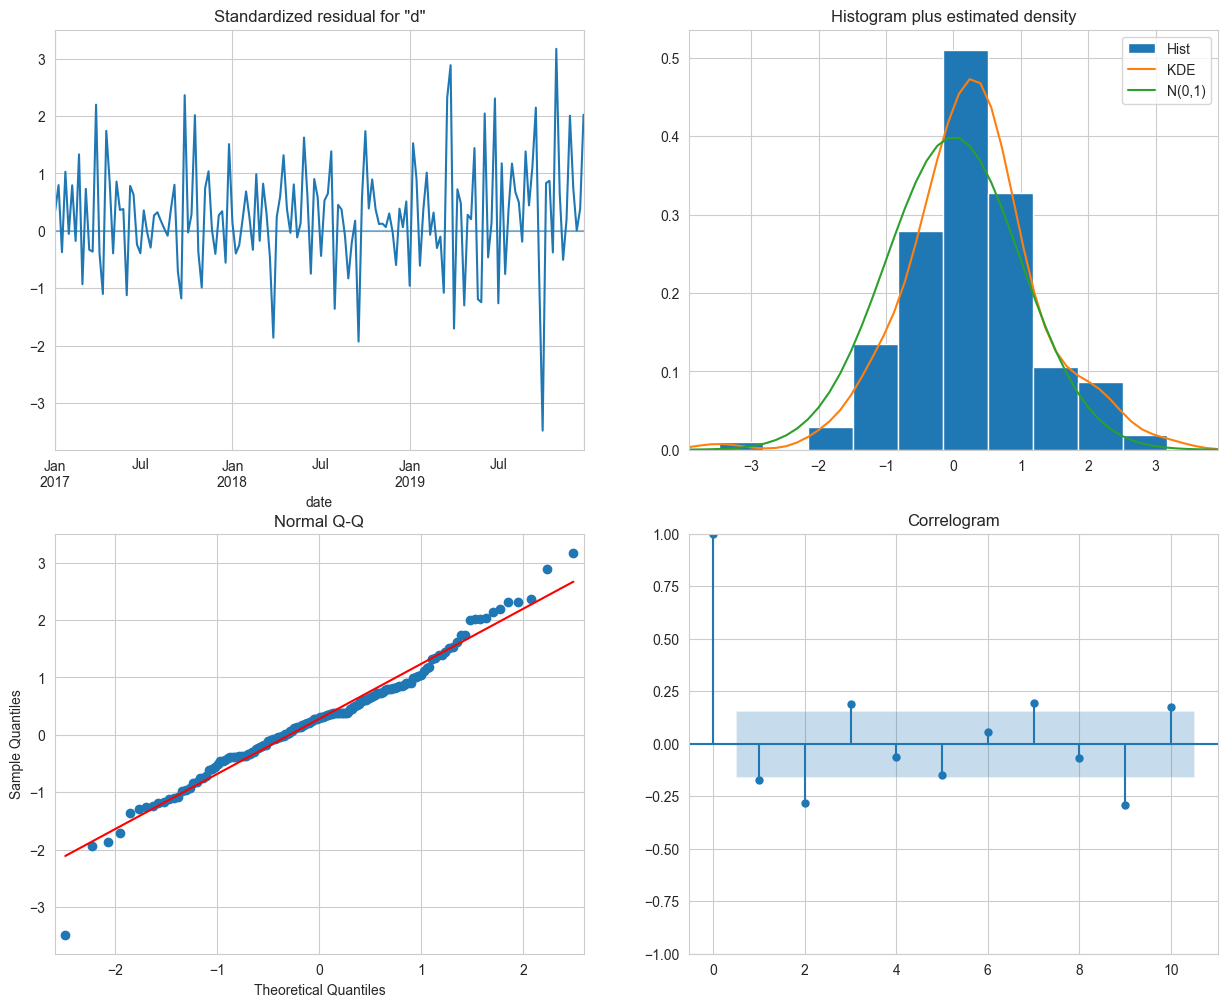

In [49]:
# SARIMA 1, 0, 0
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['diff_credit_card_purchases'], exog=data['diff_gdp'], order=(1, 0, 0))
first_model_results = model.fit()

# Print the summary of the model
print(first_model_results.summary())
first_model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

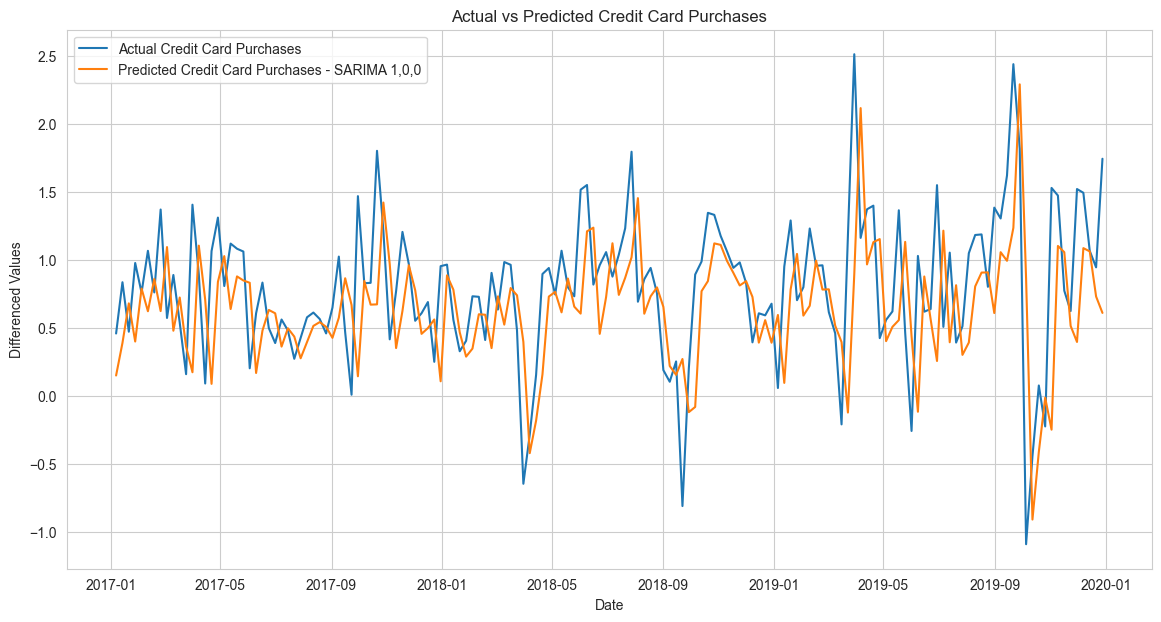

In [50]:
# Predict the values
data['first_model_predicted'] = first_model_results.predict(start=0, end=len(data)-1, exog=data['diff_gdp'])

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['diff_credit_card_purchases'], label='Actual Credit Card Purchases')
plt.plot(data.index, data['first_model_predicted'], label='Predicted Credit Card Purchases - SARIMA 1,0,0')
plt.legend()
plt.title('Actual vs Predicted Credit Card Purchases')
plt.xlabel('Date')
plt.ylabel('Differenced Values')
plt.show()

                                   SARIMAX Results                                    
Dep. Variable:     diff_credit_card_purchases   No. Observations:                  156
Model:                       SARIMAX(1, 1, 0)   Log Likelihood                -134.992
Date:                        Sun, 08 Sep 2024   AIC                            275.984
Time:                                19:14:04   BIC                            285.114
Sample:                            01-07-2017   HQIC                           279.692
                                 - 12-28-2019                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_gdp       0.1826      0.072      2.535      0.011       0.041       0.324
ar.L1         -0.2220      0.076     -2.929      0.003      -0.371 

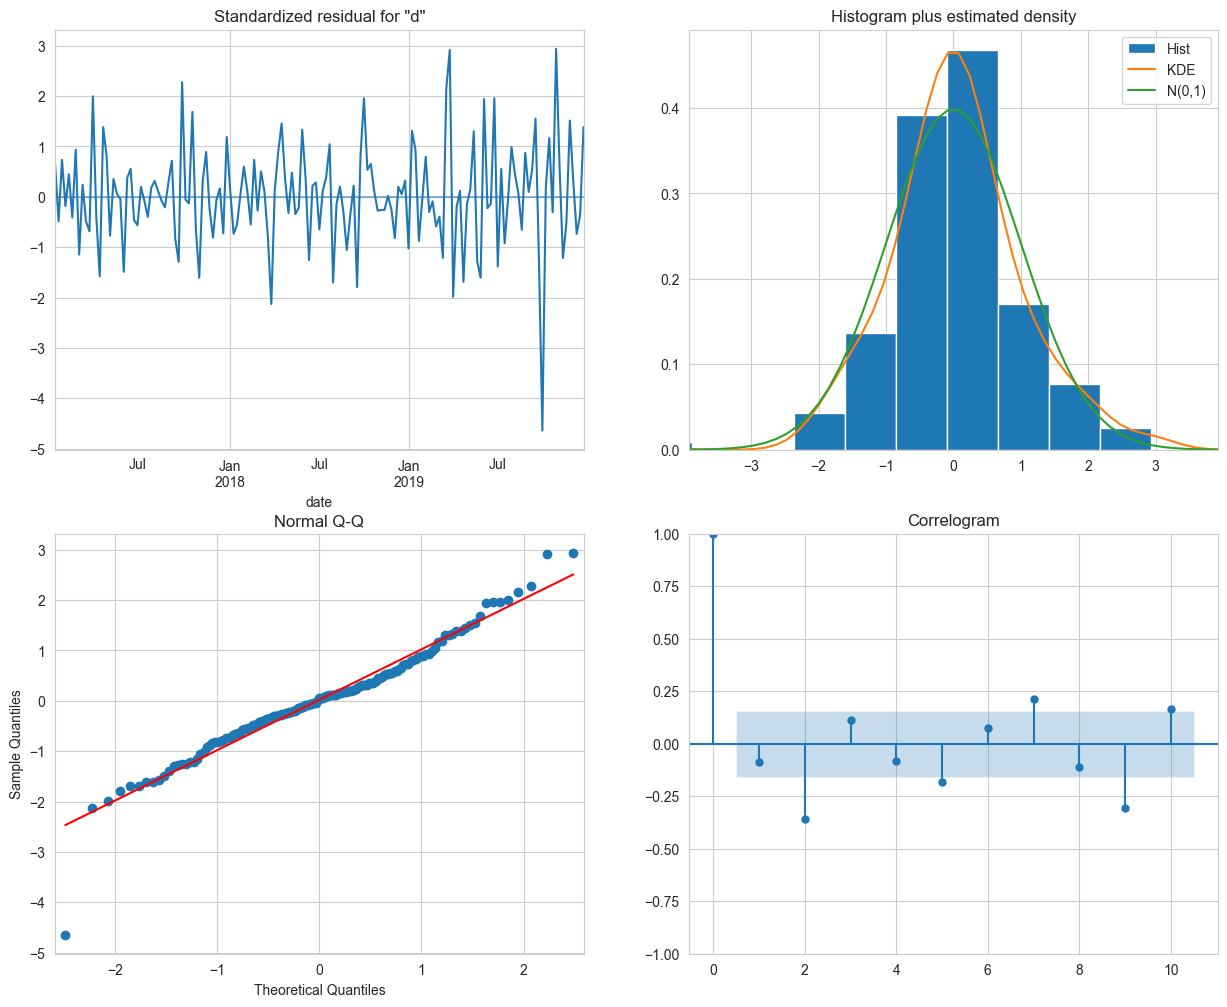

In [51]:
# SARIMA 1, 1, 0
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['diff_credit_card_purchases'], exog=data['diff_gdp'], order=(1, 1, 0))
second_model_results = model.fit()

# Print the summary of the model
print(second_model_results.summary())
second_model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

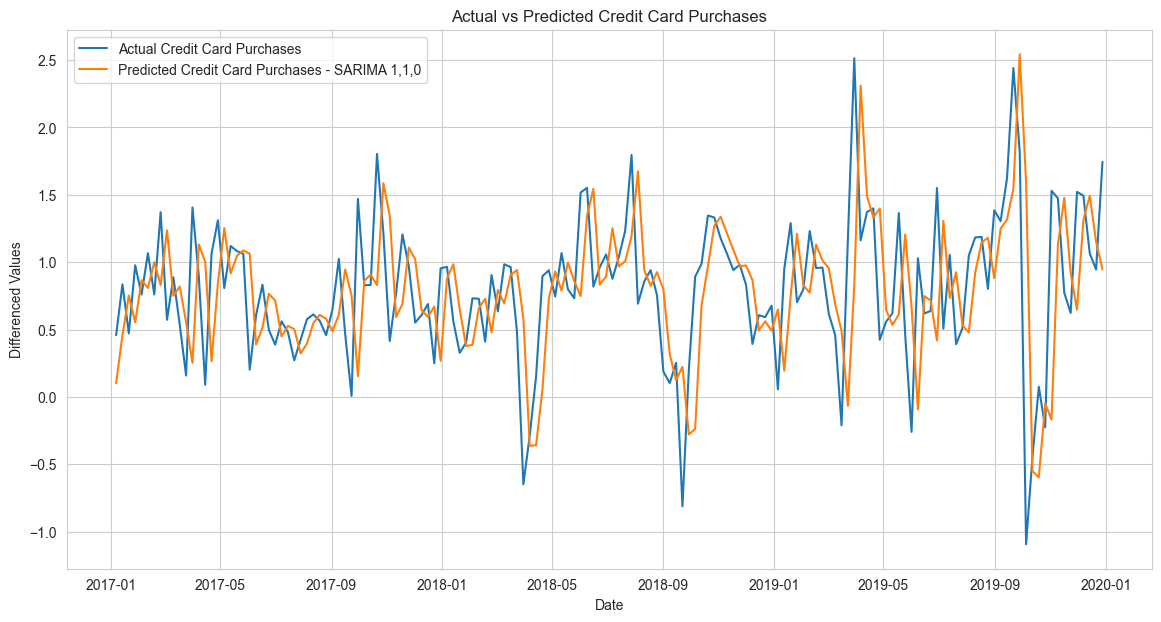

In [52]:
# Predict the values
data['second_model_predicted'] = second_model_results.predict(start=0, end=len(data)-1, exog=data['diff_gdp'])

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['diff_credit_card_purchases'], label='Actual Credit Card Purchases')
plt.plot(data.index, data['second_model_predicted'], label='Predicted Credit Card Purchases - SARIMA 1,1,0')
plt.legend()
plt.title('Actual vs Predicted Credit Card Purchases')
plt.xlabel('Date')
plt.ylabel('Differenced Values')
plt.show()

In [53]:
# SARIMAX (1, 0, 0), (0, 2, 0, 51)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['diff_credit_card_purchases'], exog=data['diff_gdp'], order=(1, 0, 0), seasonal_order=(0, 2, 0, 51), enforce_stationarity=False, enforce_invertibility=False)
third_model_results = model.fit()

# Print the summary of the model
print(third_model_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:         diff_credit_card_purchases   No. Observations:                  156
Model:             SARIMAX(1, 0, 0)x(0, 2, 0, 51)   Log Likelihood                 -85.520
Date:                            Sun, 08 Sep 2024   AIC                            177.040
Time:                                    19:17:17   BIC                            182.951
Sample:                                01-07-2017   HQIC                           179.313
                                     - 12-28-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_gdp      -0.0834      0.184     -0.454      0.650      -0.443       0.277
ar.L1          0.5777      0.150   

In [54]:
third_model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1500x1200 with 0 Axes>

In [ ]:
# Predict the values
data['third_model_predicted'] = third_model_results.predict(start=0, end=len(data)-1, exog=data['diff_gdp'])

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['diff_credit_card_purchases'], label='Actual Credit Card Purchases')
plt.plot(data.index, data['third_model_predicted'], label='Predicted Credit Card Purchases - SARIMA (1, 0, 0), (0, 2, 0, 51)')
plt.legend()
plt.title('Actual vs Predicted Credit Card Purchases')
plt.xlabel('Date')
plt.ylabel('Differenced Values')
plt.show()

In [ ]:
# Plot both models predicted values in the same graph
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['diff_credit_card_purchases'], label='Actual Credit Card Purchases')
plt.plot(data.index, data['first_model_predicted'], label='Predicted Credit Card Purchases - SARIMA 1,0,0')
plt.plot(data.index, data['second_model_predicted'], label='Predicted Credit Card Purchases - SARIMA 1,1,0')
plt.plot(data.index, data['third_model_predicted'], label='Predicted Credit Card Purchases - SARIMA (1, 0, 0), (0, 2, 0, 51)')
plt.legend()
plt.title('Actual vs Predicted Credit Card Purchases')
plt.xlabel('Date')
plt.ylabel('Differenced Values')
plt.show()